In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA




In [40]:
# data =  pd.read_csv('training_data_fall2024.csv', sep=',')
data =  pd.read_csv('modified_training.csv', sep=',')


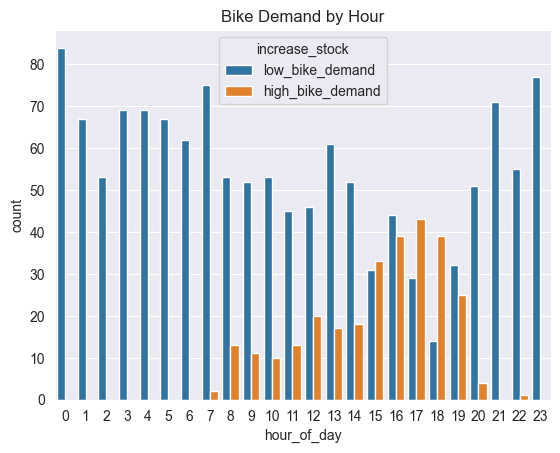

In [41]:
sns.countplot(x="hour_of_day", hue="increase_stock", data=data)
plt.title("Bike Demand by Hour")
plt.show()

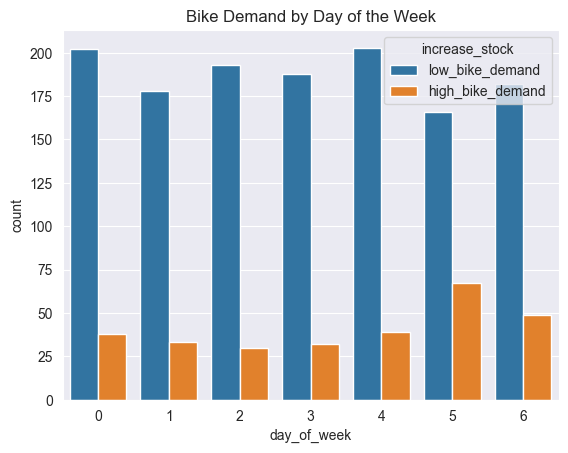

In [42]:
sns.countplot(x="day_of_week", hue="increase_stock", data=data)
plt.title("Bike Demand by Day of the Week")
plt.show()



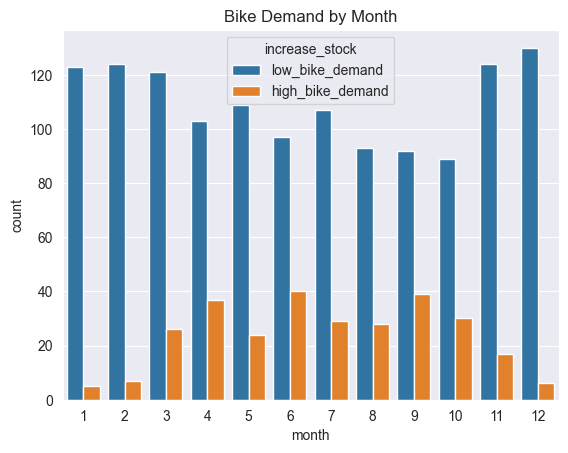

In [43]:
sns.countplot(x="month", hue="increase_stock", data=data)
plt.title("Bike Demand by Month")
plt.show()

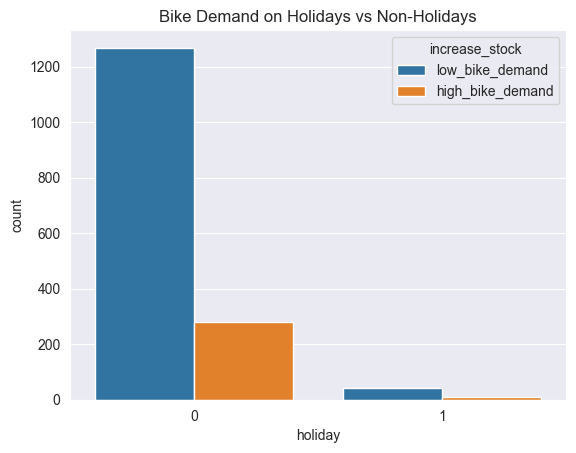

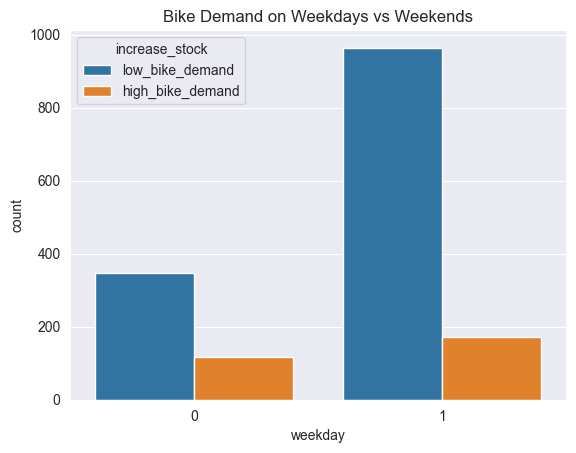

In [44]:
# Holiday vs Non-Holiday
sns.countplot(x="holiday", hue="increase_stock", data=data)
plt.title("Bike Demand on Holidays vs Non-Holidays")
plt.show()

# Weekday vs Weekend
sns.countplot(x="weekday", hue="increase_stock", data=data)
plt.title("Bike Demand on Weekdays vs Weekends")
plt.show()


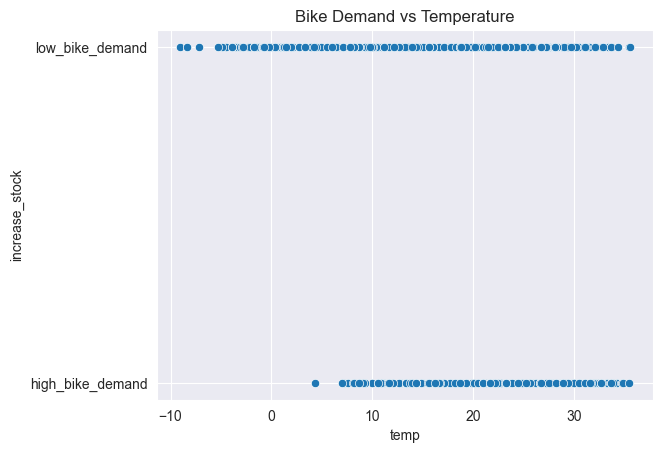

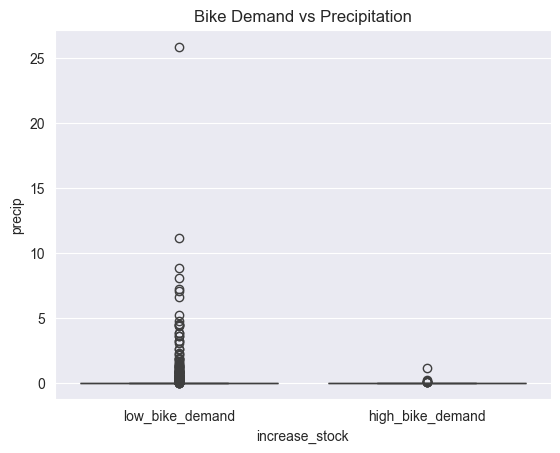

In [45]:
# Temperature vs Demand
sns.scatterplot(x="temp", y="increase_stock", data=data)
plt.title("Bike Demand vs Temperature")
plt.show()

# Precipitation vs Demand
sns.boxplot(x="increase_stock", y="precip", data=data)
plt.title("Bike Demand vs Precipitation")
plt.show()

# # Snow vs Demand
# sns.boxplot(x="increase_stock", y="snow", data=data)
# plt.title("Bike Demand vs Snow")
# plt.show()


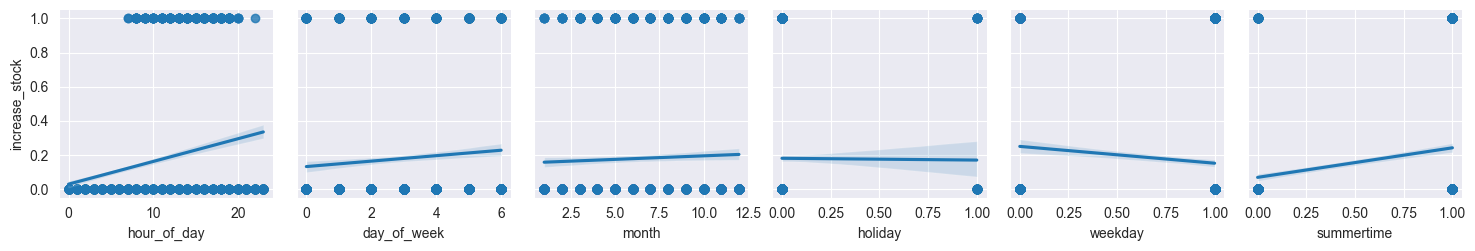

In [46]:
temp_data = data.copy()
temp_data['increase_stock'] = data['increase_stock'].map({'high_bike_demand': 1, 'low_bike_demand': 0})
sns.pairplot(temp_data, y_vars=['increase_stock'], x_vars=['hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday', 'summertime',], kind='reg')

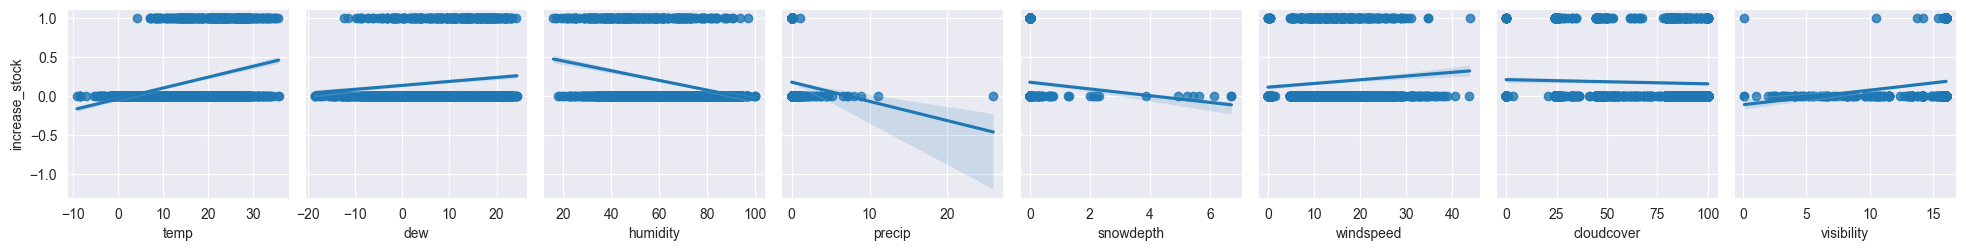

In [47]:
sns.pairplot(temp_data, y_vars=['increase_stock'], x_vars=['temp','dew','humidity','precip','snowdepth','windspeed','cloudcover','visibility'], kind='reg')

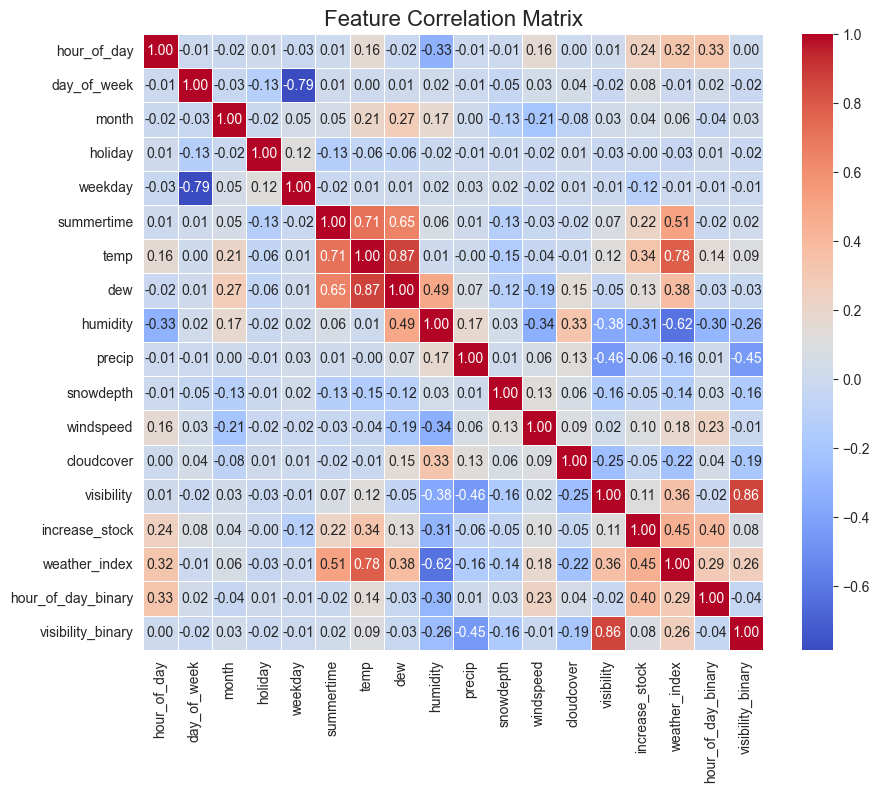

In [48]:
# Visualize the correlation matrix
correlation_matrix = temp_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()

In [49]:
y = temp_data['increase_stock']
x = temp_data.drop(columns=['increase_stock'])
x['hour_of_day_binary'] = x['hour_of_day'].apply(lambda x: 1 if 7 <= x <= 20 else 0)
x['visibility_binary'] = x['visibility'].apply(lambda x: 1 if 8 < x else 0)
# weather_features = ['temp', 'humidity', 'precip', 'snowdepth']
scaler = StandardScaler()

# x['weather_index'] = (x['temp'] + (100 - x['humidity']) + (100 - x['precip']) + x['dew']) / 4
# scaled_weather = scaler.fit_transform(x[weather_features])
#
# pca = PCA(n_components=1)  # We want to reduce to 1 principal component
# x['weather_index_pca'] = pca.fit_transform(scaled_weather)
random_state = 42








In [50]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y,random_state=random_state)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Accuracy: 0.896875
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       262
           1       0.74      0.67      0.70        58

    accuracy                           0.90       320
   macro avg       0.83      0.81      0.82       320
weighted avg       0.89      0.90      0.90       320



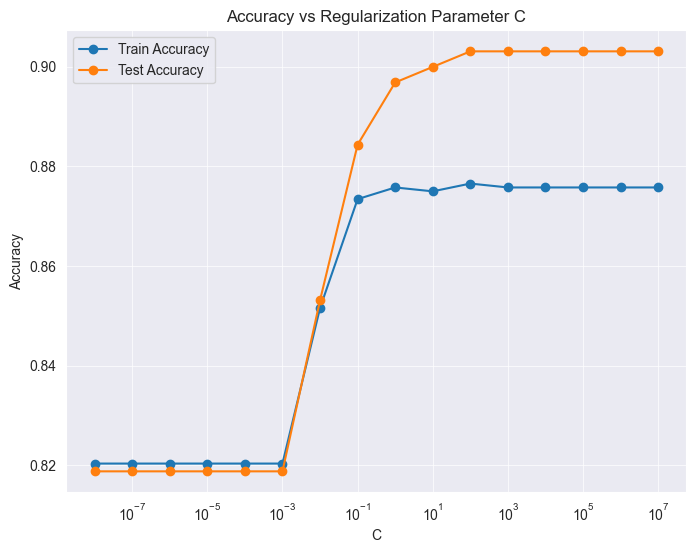

In [51]:
log_reg = LogisticRegression(max_iter=5000)

# Train the model
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

scores = {}
for C in (10**k for k in range(-8, 8)):
    lr = LogisticRegression(C=C, max_iter=5000)
    lr.fit(x_train, y_train)
    scores[C] = {'train accuracy': lr.score(x_train, y_train),
                 'test accuracy': lr.score(x_test, y_test)}

# plot the accuracy scores for different values of C
Cs = list(scores.keys())
train_accuracies = [score['train accuracy'] for score in scores.values()]
test_accuracies = [score['test accuracy'] for score in scores.values()]

# Plot using matplotlib
plt.figure(figsize=(8, 6))
plt.plot(Cs, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(Cs, test_accuracies, marker='o', label='Test Accuracy')

# Log scale for x-axis
plt.xscale('log')

# Adding labels and title
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Regularization Parameter C')
plt.legend()
plt.grid(True, which="both", linestyle='-', linewidth=0.5)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=y.unique().astype(str)))

In [52]:
# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Solvers
    'penalty': ['l2']  # Regularization penalties
}

# Perform grid search
grid_search = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5, scoring='accuracy',error_score='raise')
grid_search.fit(x_train, y_train)

# Best parameters# Extract best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Test the model on the test set
y_pred = best_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Print the results
print("Best Parameters:", best_params)
print("Accuracy on Test Set:", accuracy)
print("\nClassification Report:\n", classification_report_result)

Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy on Test Set: 0.903125

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       262
           1       0.75      0.69      0.72        58

    accuracy                           0.90       320
   macro avg       0.84      0.82      0.83       320
weighted avg       0.90      0.90      0.90       320



In [53]:
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors

# Train the KNN model
knn.fit(x_train, y_train)

# Make predictions
y_pred_knn = knn.predict(x_test)

# Evaluate the model
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=data['increase_stock'].unique().astype(str)))

KNN Accuracy: 0.85625
                  precision    recall  f1-score   support

 low_bike_demand       0.90      0.92      0.91       262
high_bike_demand       0.62      0.55      0.58        58

        accuracy                           0.86       320
       macro avg       0.76      0.74      0.75       320
    weighted avg       0.85      0.86      0.85       320



In [60]:
param_grid = {
    'n_estimators': [50, 100, 200,500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search_rf.fit(x_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
y_pred = best_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Print the results
print("Accuracy on Test Set:", accuracy)
print("\nClassification Report:\n", classification_report_result)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy on Test Set: 0.65

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.58      0.73       262
           1       0.34      0.97      0.50        58

    accuracy                           0.65       320
   macro avg       0.66      0.77      0.62       320
weighted avg       0.87      0.65      0.69       320



In [55]:
random_forest = RandomForestClassifier(random_state= random_state)  # Default 100 trees

# Train the Random Forest model
random_forest.fit(x_train, y_train)

# Make predictions
y_pred_rf = random_forest.predict(x_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
CV = cross_val_score(random_forest,x_train,y_train,cv=5)
print(f'Mean cross validation{CV.mean():.2f}')
print(classification_report(y_test, y_pred_rf, target_names=data['increase_stock'].unique().astype(str)))

Random Forest Accuracy: 0.93125
Mean cross validation0.89
                  precision    recall  f1-score   support

 low_bike_demand       0.94      0.98      0.96       262
high_bike_demand       0.89      0.71      0.79        58

        accuracy                           0.93       320
       macro avg       0.91      0.84      0.87       320
    weighted avg       0.93      0.93      0.93       320



In [56]:
lda = LinearDiscriminantAnalysis()

# Train the LDA model
lda.fit(x_train, y_train)

# Make predictions
y_pred_lda = lda.predict(x_test)

# Evaluate the model
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda, target_names=data['increase_stock'].unique().astype(str)))



LDA Accuracy: 0.8625
                  precision    recall  f1-score   support

 low_bike_demand       0.89      0.95      0.92       262
high_bike_demand       0.67      0.48      0.56        58

        accuracy                           0.86       320
       macro avg       0.78      0.71      0.74       320
    weighted avg       0.85      0.86      0.85       320



In [57]:
qda = QuadraticDiscriminantAnalysis()

# Train the QDA model
qda.fit(x_train, y_train)

# Make predictions
y_pred_qda = qda.predict(x_test)

# Evaluate the model
print("QDA Accuracy:", accuracy_score(y_test, y_pred_qda))
print(classification_report(y_test, y_pred_qda, target_names=data['increase_stock'].unique().astype(str)))


QDA Accuracy: 0.81875
                  precision    recall  f1-score   support

 low_bike_demand       0.82      1.00      0.90       262
high_bike_demand       0.00      0.00      0.00        58

        accuracy                           0.82       320
       macro avg       0.41      0.50      0.45       320
    weighted avg       0.67      0.82      0.74       320



C:\Users\Alina Lånedator\sml\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Alina Lånedator\sml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alina Lånedator\sml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alina Lånedator\sml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s

In [58]:
# Initialize the Naive Bayes model
naive_bayes = GaussianNB()

# Train the model
naive_bayes.fit(x_train, y_train)

# Predict on the test set
y_pred = naive_bayes.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

# Precision, Recall, and F1-Score
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=y.unique().astype(str)))

Accuracy: 0.64375

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.57      0.72       262
           1       0.33      0.97      0.50        58

    accuracy                           0.64       320
   macro avg       0.66      0.77      0.61       320
weighted avg       0.87      0.64      0.68       320



In [59]:
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Initialize Gaussian Naive Bayes
naive_bayes = GaussianNB()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Best hyperparameters and model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Test the best model
y_pred = best_model.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=y.unique().astype(str)))


Best Parameters: {'var_smoothing': 1e-05}
Accuracy: 0.65

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.58      0.73       262
           1       0.34      0.97      0.50        58

    accuracy                           0.65       320
   macro avg       0.66      0.77      0.62       320
weighted avg       0.87      0.65      0.69       320

